# Fundamentals of Software Systems (FSS)
**Software Evolution – Part 02 Assignment**

## Submission Guidelines

To correctly complete this assignment you must:
* Carry out the assignment in a team of 2 to 4 students.
* Carry out the assignment with your team only. You are allowed to discuss solutions with other teams, but each team should come up its own personal solution. A strict plagiarism policy is going to be applied to all the artifacts submitted for evaluation.
* As your submission, upload the filled Jupyter Notebook (including outputs) together with the d3 visualization web pages (i.e. upload everything you downloaded including the filled Jupyter Notebook plus your `output.json`)
* The files must be uploaded to OLAT as a single ZIP (`.zip`) file by Dec 15, 2025 @ 23:55.


## Group Members
* Noah, Ziegler, 22-701-031
* **TO BE FILLED**

## Task Context

In this assigment we will be analyzing the _elasticsearch_ project. All following tasks should be done with the subset of commits from tag `v1.0.0` to tag `v1.1.0`.

## Task 1: Author analysis

In the following, please consider only `java` files.

The first task is to get an overview of the author ownership of the _elasticsearch_ project. In particular, we want to understand who are the main authors in the system between the two considered tags, the authors distribution among files and the files distribution among authors. To this aim, perform the following:
- create a dictionary (or a list of tuples) with the pairs author => number of modified files
- create a dictionary (or a list of tuples) with the pairs file => number of authors who modified the file
- visualize the distribution of authors among files: the visualization should have on the x axis the number of authors per file (from 1 to max), and on the y axis the number of files with the given number of authors (so for example the first bar represent the number of files with single author)
- visualize the distribution of files among authors: the visualization should have on the x axis the number of files per author (from 1 to max), and on the y axis the number of authors that own the given number of files (so for example the first bar represent the minor contributors, i.e., the number of authors who own 1 file)

Comment the two distribution visualizations.



Now, let's look at the following 3 packages in more details:
1. `src/main/java/org/elasticsearch/search`
2. `src/main/java/org/elasticsearch/index`
3. `src/main/java/org/elasticsearch/action`

Create a function that, given the path of a package and a modification type (see class Modification above), returns a dictionary of authors => number, where the number counts the total lines added or removed or added+removed or added-removed (depending on the given Modification parameter), for the given package. To compute the value at the package level, you should aggregate the data per file.

Using the function defined above, visualize the author contributions (lines added + lines removed). The visualization should have the author on the x axis, and the total lines on the y axis. Sort the visualization in decreasing amount of contributions, i.e., the main author should be the first.

Compare the visualization for the 3 packages and comment.

Total unique authors: 55
Total unique Java files modified: 4009
Top 5 authors by number of files modified:
  Simon Willnauer: 3752 files
  Shay Banon: 803 files
  Martijn van Groningen: 745 files
  Adrien Grand: 522 files
  Andrew Raines: 413 files


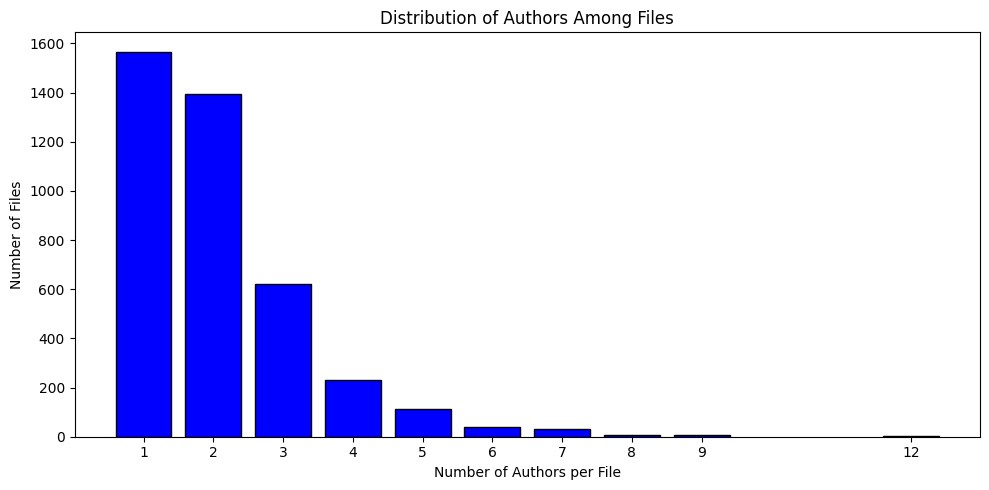

Outlier excluded from graphs: 1 author(s) with 3752 files


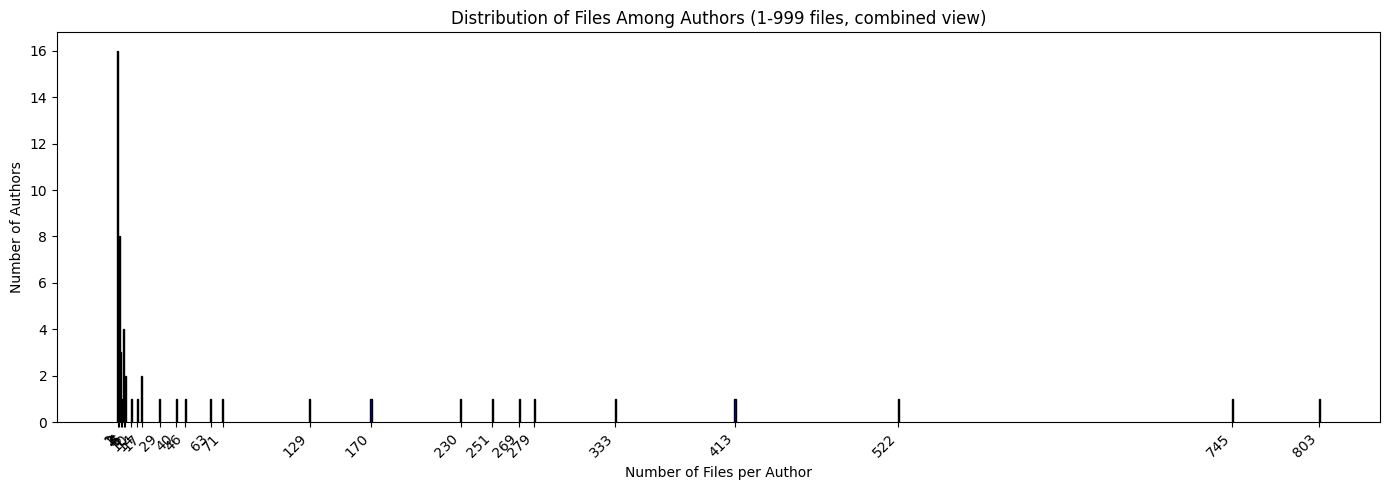

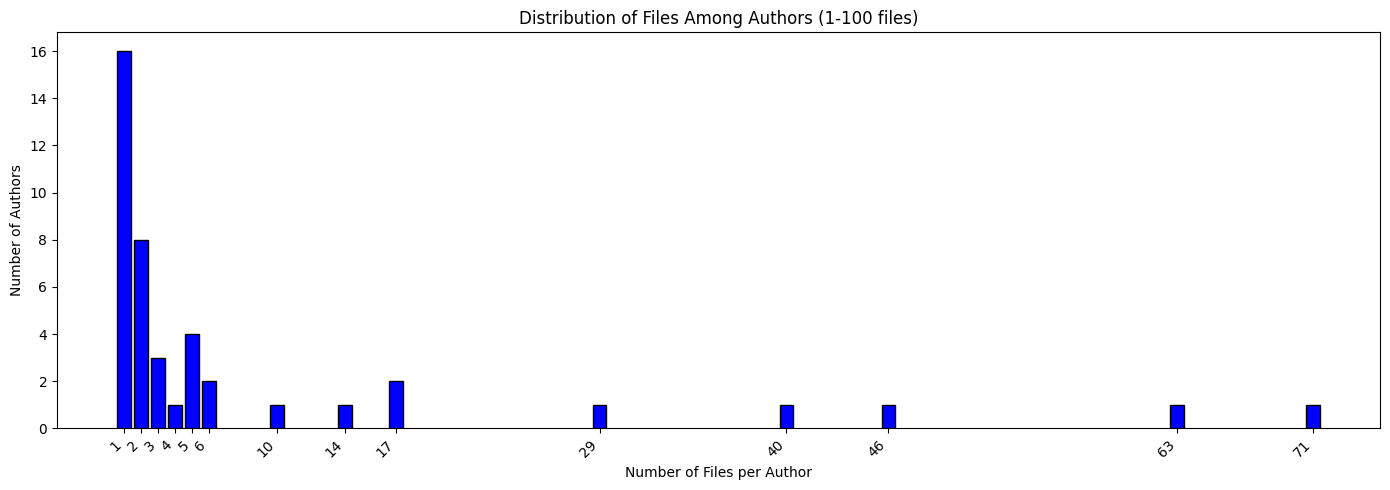

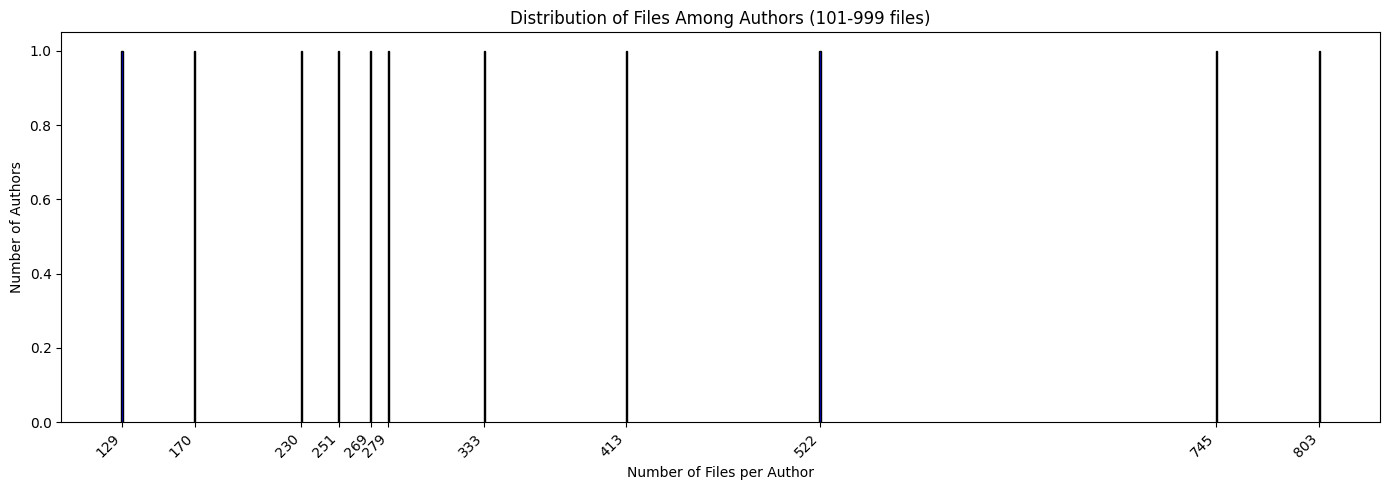

In [ ]:
from enum import Enum
import pydriller
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
class Modification(Enum):
    ADDED = "Lines added"
    REMOVED = "Lines removed"
    TOTAL = "Lines added + lines removed"
    DIFF = "Lines added - lines removed"

#local path to elasticsearch repo
repo_path = "C:/Users/noahz/Downloads/elasticsearch" 
repo = pydriller.Repository(repo_path, from_tag="v0.90.0", to_tag="v1.0.0.RC1")


#PART 1: GENERAL AUTHOR ANALYSIS
author_to_files = defaultdict(set) #author_name -> {set of file paths}
file_to_authors = defaultdict(set) #file_path -> {set of author names}
for commit in repo.traverse_commits():
    author_name = commit.author.name
    for mod in commit.modified_files:
          if mod.filename.endswith('.java'): #java only files
            filepath = mod.new_path if mod.new_path else mod.old_path #new_path for added/modified, old_path for deleted
            if filepath:  # Safety check
                author_to_files[author_name].add(filepath)
                file_to_authors[filepath].add(author_name)

author_file_count = {author: len(files) for author, files in author_to_files.items()} #author_name -> {number of modified files}
file_author_count = {filepath: len(authors) for filepath, authors in file_to_authors.items()} #file_path -> {number of authors who modified}

print(f"Total unique authors: {len(author_file_count)}")
print(f"Total unique Java files modified: {len(file_author_count)}")

# Preview the data
print("Top 5 authors by number of files modified:")
sorted_authors = sorted(author_file_count.items(), key=lambda x: x[1], reverse=True)
for author, count in sorted_authors[:5]:
    print(f"  {author}: {count} files")


authors_per_file_distribution = Counter(file_author_count.values()) # creates distribution
files_per_author_distribution = Counter(author_file_count.values()) # creates distribution

x1 = sorted(authors_per_file_distribution.keys()) 
y1 = [authors_per_file_distribution[x] for x in x1]  

# Distribution of authors among files
plt.figure(figsize=(10, 5))
plt.bar(x1, y1, color='blue', edgecolor='black')
plt.xlabel('Number of Authors per File')
plt.ylabel('Number of Files')
plt.title('Distribution of Authors Among Files')
plt.xticks(x1)  
plt.tight_layout()
plt.show()

# Distribution of files among authors
x2 = sorted(files_per_author_distribution.keys())
y2 = [files_per_author_distribution[x] for x in x2]

# Filter into groups, so that graph doesent get cramped and unreadable
x2_combined = [x for x in x2 if x < 1000]
y2_combined = [files_per_author_distribution[x] for x in x2_combined]

x2_small = [x for x in x2 if x <= 100]
y2_small = [files_per_author_distribution[x] for x in x2_small]

x2_medium = [x for x in x2 if 100 < x < 1000]
y2_medium = [files_per_author_distribution[x] for x in x2_medium]

# OUTLIERS ABOVE 1000 PRINTED TO CONSOLE (ONLY 1)
outliers = [x for x in x2 if x >= 1000]
for o in outliers:
    print(f"Outlier excluded from graphs: {files_per_author_distribution[o]} author(s) with {o} files")


# Graph 1: Combined 1-999 files (overview) - is a bit cramped
plt.figure(figsize=(14, 5))
plt.bar(x2_combined, y2_combined, color='blue', edgecolor='black')
plt.xlabel('Number of Files per Author')
plt.ylabel('Number of Authors')
plt.title('Distribution of Files Among Authors (1-999 files, combined view)')
plt.xticks(x2_combined, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Graph 2: 0-100 files
plt.figure(figsize=(14, 5))
plt.bar(x2_small, y2_small, color='blue', edgecolor='black')
plt.xlabel('Number of Files per Author')
plt.ylabel('Number of Authors')
plt.title('Distribution of Files Among Authors (1-100 files)')
plt.xticks(x2_small, rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Graph 3: 100-1000 files
plt.figure(figsize=(14, 5))
plt.bar(x2_medium, y2_medium, color='blue', edgecolor='black')
plt.xlabel('Number of Files per Author')
plt.ylabel('Number of Authors')
plt.title('Distribution of Files Among Authors (101-999 files)')
plt.xticks(x2_medium, rotation=45, ha='right')
plt.tight_layout()
plt.show()


    

### Comment the two distribution visualizations.
In the *first distribution* showing the number of files that have 1-12 authors we can see that most files have 1 or 2 authors. This means that there is strong code ownership - single developers own specific files. However there is also a healthy amount of files that have between 3 and 7 developers showing that collaboration also takes place. Then there are very few outliers, having 8-12 authors which might suggest that these files are hotspots. 

In the *second distribution* showing how many files an author has we can see that there are many developers contributing only a little (1-10) files. Then there are very few contributing between 10-100 files. But then we can see the interesting part: there are a few "super contributers" which contributed over 100 up until 3752 files. So we can see here that this project relies heavily on a small core team, and there are many small contributers additionally. 
--> This project has a LOW bus factor (only few poeple need to leave until project is in serious trouble). If a few top contributers leave (eg Simon Willnauer or Shay Banon), this project is in serious trouble. 

Analyzing: src/main/java/org/elasticsearch/search
Processed 250 commits so far
Processed 500 commits so far
Processed 750 commits so far
Processed 1000 commits so far
Processed 1250 commits so far
Processed 1500 commits so far
Processed 1750 commits so far


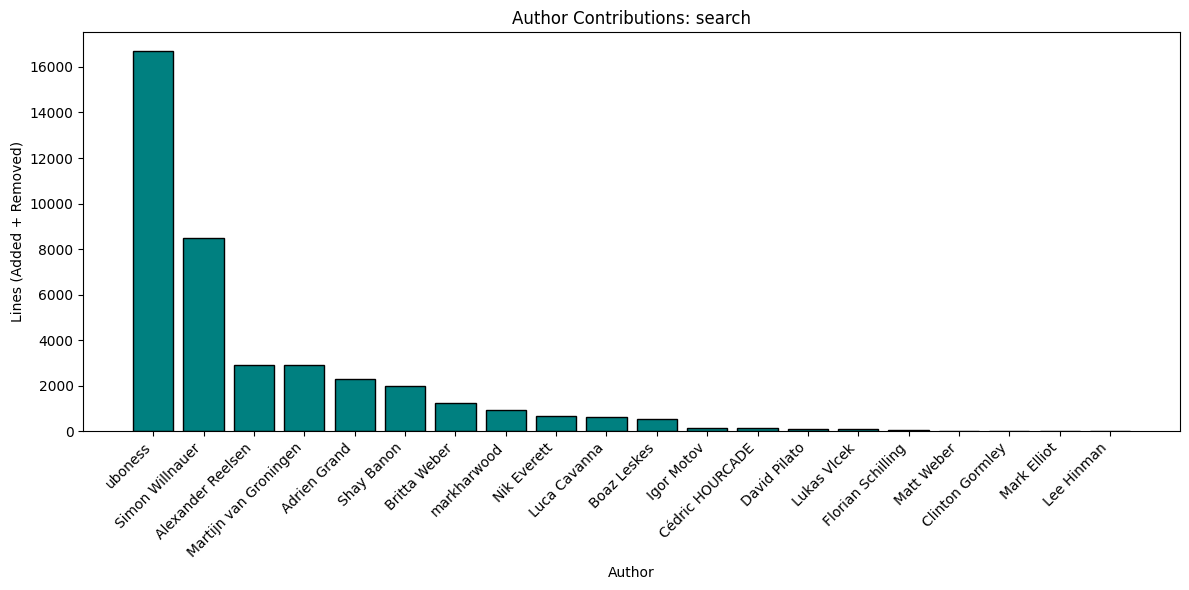

Analyzing: src/main/java/org/elasticsearch/index
Processed 250 commits so far
Processed 500 commits so far
Processed 750 commits so far
Processed 1000 commits so far
Processed 1250 commits so far
Processed 1500 commits so far
Processed 1750 commits so far


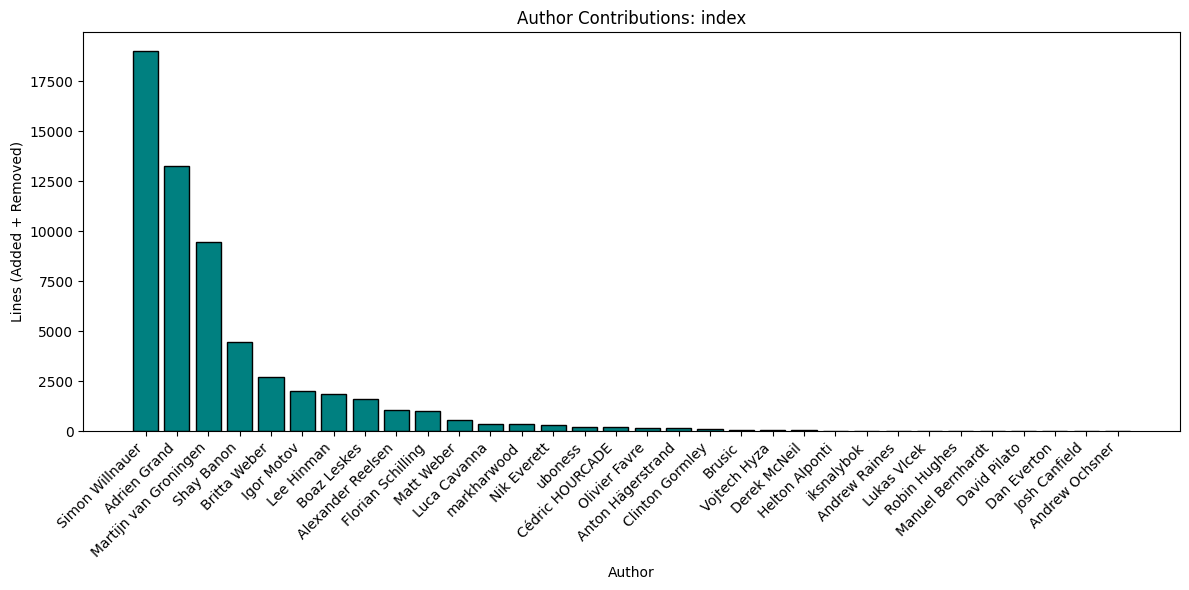

Analyzing: src/main/java/org/elasticsearch/action
Processed 250 commits so far
Processed 500 commits so far
Processed 750 commits so far
Processed 1000 commits so far
Processed 1250 commits so far
Processed 1500 commits so far
Processed 1750 commits so far


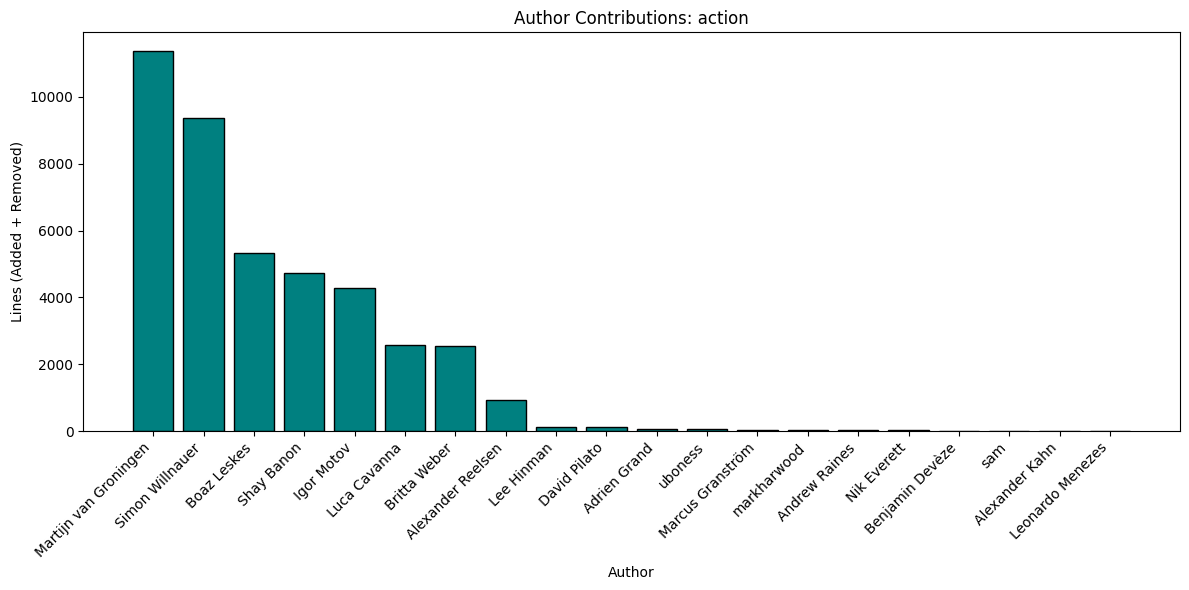

In [5]:
#PART 2: PACKAGE SPECIFIC AUTHOR ANALYSIS
from enum import Enum
import pydriller
import matplotlib.pyplot as plt
from collections import defaultdict

class Modification(Enum):
    ADDED = "Lines added"
    REMOVED = "Lines removed"
    TOTAL = "Lines added + lines removed"
    DIFF = "Lines added - lines removed"
repo_path = "C:/Users/noahz/Downloads/elasticsearch" 
packages = [
    "src/main/java/org/elasticsearch/search",
    "src/main/java/org/elasticsearch/index",
    "src/main/java/org/elasticsearch/action"
]

def get_author_contributions(repo_path, package_path, mod_type):
    count = 0
    contributions = defaultdict(int)
    repo = pydriller.Repository(repo_path, from_tag="v0.90.0", to_tag="v1.0.0.RC1")
    
    for commit in repo.traverse_commits():
        count += 1
        if count % 250 == 0:
            print(f"Processed {count} commits so far")
        author_name = commit.author.name
        
        for mod in commit.modified_files:
            if mod.filename.endswith('.java'): #java only files
                filepath = mod.new_path if mod.new_path else mod.old_path #new_path for added/modified, old_path for deleted
                filepath = filepath.replace('\\', '/') #normalize path
                if filepath and filepath.startswith(package_path):
                    added = mod.added_lines
                    removed = mod.deleted_lines
                    
                    if mod_type == Modification.ADDED:
                        value = added
                    elif mod_type == Modification.REMOVED:
                        value = removed
                    elif mod_type == Modification.TOTAL:
                        value = added + removed
                    elif mod_type == Modification.DIFF:
                        value = added - removed
                    else:
                        print("Invalid Modification Type")
                        value = 0
                    contributions[author_name] += value
    
    return dict(contributions)

def plot_author_contributions(contributions, package_name):
    sorted_contributions = sorted(contributions.items(), key=lambda x: x[1], reverse=True)
    authors = [item[0] for item in sorted_contributions]
    lines = [item[1] for item in sorted_contributions]

    plt.figure(figsize=(12, 6))
    x_positions = range(len(authors))
    plt.bar(x_positions, lines, color='teal', edgecolor='black')
    plt.xticks(x_positions, authors, rotation=45, ha='right')
    plt.xlabel('Author')
    plt.ylabel('Lines (Added + Removed)')
    plt.title(f'Author Contributions: {package_name}')
    plt.tight_layout()
    plt.show()

for package in packages:
    print(f"Analyzing: {package}")
    contributions = get_author_contributions(repo_path, package, Modification.TOTAL)
    short_name = package.split('/')[-1]  #short package name for the title
    plot_author_contributions(contributions, short_name)

### Compare the visualization for the 3 packages and comment

We can see for all  packages that they have a few core contributors (super contributors) which doe MOST of the code changes and then many other which do a few. 
This aligns with the results we have seen in the previous graph. This shows very well that this project is Open source where there is a core team that works on it any many other open source contributers that contribute just a tiny bit. 

Also here we can see that Simon Willnauer, Shay Bannon, Martijn van Groningen... are the very core team contributors. So again we can nicely see that this project has a low truck factor (bad); if the core team leaves the project is in serious trouble. 

For the distinction of the 3 packages.
- The action package had a little less changes than index and search, but nothing unusual. --> They all follow the same pattern of: few core contributors, many small contributors. 
    - Possibly you can say that Search has uboness as a clear owner (clearly highest modified lines) while the other packages are a bit more balanced. --> So in the search package uboness is the clear code owner while in the others it is shared between multiple core contributors.
- Whats special to see is that all 3 packages have an extremely HIGH Lines changed count. The top contributor has over 10000 lines changed in all 3 of them, overall with all contributors  all 3 packages have over 40000 lines changed --> these packages were highly modified.

## Task 2: Knowledge loss

We now want to analyze the knowledge loss when the main contributor of the analyzed project would leave. For this we will use the circle packaging layout introduced in the "Code as a Crime Scene" book. This assignment includes the necessary `knowledge_loss.html` file as well as the `d3` folder for all dependencies. You task is to create the `output.json` file according to the specification below. This file can then be visualized with the files provided.

For showing the visualization, once you have the output as `output.json` you should
* make sure to have the `knowledge_loss.html` file in the same folder
* start a local HTTP server in the same folder (e.g. with python `python3 -m http.server`) to serve the html file (necessary for d3 to work)
* open the served `knowledge_loss.html` and look at the visualization

For the package you identify as the worst in terms of knowledge loss, investigate the author contributions using the function defined in the previous exercise and comment how the situation is, e.g. how big the gap between the main author and the second biggest contributor for the selected package is.

### Output Format for Visualization

* `root` is always the root of the tree
* `size` should be the total number of lines of contribution
* `weight` can be set to the same as `size`
* `ownership` should be set to the percentage of contributions from the main author (e.g. 0.98 for 98% if contributions coming from the main author)

```
{
  "name": "root",
  "children": [
    {
      "name": "test",
      "children": [
        {
          "name": "benchmarking",
          "children": [
            {
              "author_color": "red",
              "size": "4005",
              "name": "t6726-patmat-analysis.scala",
              "weight": 1.0,
              "ownership": 0.9,
              "children": []
            },
            {
              "author_color": "red",
              "size": "55",
              "name": "TreeSetIterator.scala",
              "weight": 0.88,
              "ownership": 0.9,
              "children": []
            }
          ]
        }
      ]
    }
  ]
}
```

### JSON Export

For exporting the data to JSON you can use the following snippet:

```
import json

with open("output.json", "w") as file:
    json.dump(tree, file, indent=4)
```

## Task 3: Code Churn Analysis

The third and last task is to analyze the code churn of the _elasticsearch_ project. For this analysis we look at the code churn, meaning the daily change in the total number of lines of the project. Visualize the code churn over time bucketing the data by day. Remember that you'll need to interpolate the data for days when there are no commits. Chose an interpolation strategy and justify it.

Look at the churn trend over time and identify two outliers. For each of them:
- identify if it was caused by a single or multiple commits (since you are bucketing the data by day)
- find the hash of the involved commit(s)
- find the involved files
- look at the actual diff

Based on the above, discuss if the outlier is a false positive or should be a reason for concern.